In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import preprocessing
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import f1_score
from scipy import sparse

print(tf.__version__)

1.12.0


In [2]:
## Import Data
GENRES_IDX = {"blues":0, "gospel":1, "rap":2, "country":3, "rock":4}
GENRE_NAMES = ["blues", "gospel", "rap", "country", "rock"]

NON_SPARSE_FEATS = ['n_wrds', 'avg_wrd_len',
       'n_lines', 'avg_line_len', 'n_contractions', 'contraction_density',
       'vocab_size', 'edge_density',
       'edge_density_weighted', 'edge_weight_var', 'degree_var',
       'degree_var_weighted', 'degree_avg', 'degree_avg_weighted',
       'comp_size_avg', 'lz_comp_ratio']

SPARSE_FEATS = ['word2vec_avg', 'topk']

N_NONSPARSE = len(NON_SPARSE_FEATS)
N_SPARSE = len(SPARSE_FEATS)

def df_to_arr(df):
    x = df[NON_SPARSE_FEATS]
    x_arr = x.values
    
    if N_SPARSE > 0:
        y_arr_list = []
        for sparse_feat in SPARSE_FEATS:
            y = df[sparse_feat]
            y_list = [list(y.values[i]) for i in range(y.values.shape[0])]
            y_arr = np.array(y_list)
            y_arr_list.append(y_arr)

        y_arr = y_arr_list[0]
        for i in range(len(y_arr_list) - 1):
            y_arr = np.concatenate((y_arr, y_arr_list[i+1]), axis=1)
    
    # Use one hot encoding labels
    kron = np.eye(5)
    labels = df["genre"].values
    labels_one_hot = np.array([kron[:, GENRES_IDX[genre]] for genre in labels])
    
    # Use integer labels
    labels_sparse = np.array([GENRES_IDX[genre] for genre in labels])
    
    if N_SPARSE > 0:
        data = np.concatenate((x_arr, y_arr), axis=1)
    else:
        data = x_arr
    return data, labels_sparse

def read_data(fn):
    df = pd.read_pickle(fn)
    df.fillna(0, inplace=True)
    df_train = df.query("data_split == 'train'").copy()
    df_test = df.query("data_split == 'test'").copy()
    df_val = df.query("data_split == 'val'").copy()

    lyrics_train = np.array(df_train["lyrics_stripped"].values)
    lyrics_test = np.array(df_test["lyrics_stripped"].values)
    lyrics_val = np.array(df_val["lyrics_stripped"].values)

    X_train, Y_train = df_to_arr(df_train)
    X_val, Y_val = df_to_arr(df_val)
    X_test, Y_test = df_to_arr(df_test)
        
    if N_NONSPARSE > 0:
        ## Standardize Data
        scaler = preprocessing.StandardScaler().fit(X_train[:, :N_NONSPARSE])
        X_train[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_train[:, :N_NONSPARSE])
        X_val[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_val[:, :N_NONSPARSE])
        X_test[:, :len(NON_SPARSE_FEATS)] = scaler.transform(X_test[:, :N_NONSPARSE])
    if N_SPARSE > 0:
        scaler_sparse = preprocessing.MinMaxScaler().fit(X_train[:, N_NONSPARSE:])
        X_train[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_train[:, N_NONSPARSE:])
        X_val[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_val[:, N_NONSPARSE:])
        X_test[:, len(NON_SPARSE_FEATS):] = scaler_sparse.transform(X_test[:, N_NONSPARSE:])
    
    return X_train, Y_train, X_val, Y_val, X_test, Y_test, lyrics_train, lyrics_val, lyrics_test

ALL_DATA_FN = "all.data"
X_train, Y_train, X_val, Y_val, X_test, Y_test,  lyrics_train, lyrics_val, lyrics_test = read_data(ALL_DATA_FN)
DIM = X_train.shape[1]

In [3]:
# Shuffle X_train and Y_train

N = X_train.shape[0]
idx = np.array([i for i in range(N)])
np.random.shuffle(idx)
X_train = X_train[idx]
Y_train = Y_train[idx]

In [5]:
# Calculate the gradients of each output node w.r.t. each input feature

inputs = tf.keras.Input(shape=(DIM,))  # Returns a placeholder tensor

# A layer instance is callable on a tensor, and returns a tensor.
# x = keras.layers.Dense(200, activation=tf.nn.relu)(inputs)
x = inputs # For single layer neural network

predictions = keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=predictions)
model.compile(optimizer=tf.train.AdamOptimizer(), 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

callbacks = [
  # Interrupt training if `val_loss` stops improving for over 2 epochs
  tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss'),
  # Write TensorBoard logs to `./logs` directory
  tf.keras.callbacks.TensorBoard(log_dir='./logs')
]

model.fit(X_train, Y_train,
          epochs=100,
          validation_data = (X_val, Y_val), 
          batch_size=32,
          callbacks=callbacks
         )

# Evaluate Model
model.evaluate(X_test, Y_test, batch_size=32)

Train on 35380 samples, validate on 11851 samples
Epoch 1/100
35380/35380 [==============================] - 6s 166us/step - loss: 1.0674 - acc: 0.6449 - val_loss: 0.8370 - val_acc: 0.7717
Epoch 2/100
35380/35380 [==============================] - 6s 164us/step - loss: 0.7218 - acc: 0.8035 - val_loss: 0.6641 - val_acc: 0.8149
Epoch 3/100
35380/35380 [==============================] - 6s 166us/step - loss: 0.5866 - acc: 0.8398 - val_loss: 0.5809 - val_acc: 0.8244
Epoch 4/100
35380/35380 [==============================] - 6s 166us/step - loss: 0.5103 - acc: 0.8586 - val_loss: 0.5326 - val_acc: 0.8352
Epoch 5/100
35380/35380 [==============================] - 5s 152us/step - loss: 0.4596 - acc: 0.8707 - val_loss: 0.4977 - val_acc: 0.8453
Epoch 6/100
35380/35380 [==============================] - 6s 176us/step - loss: 0.4220 - acc: 0.8796 - val_loss: 0.4728 - val_acc: 0.8506
Epoch 7/100
35380/35380 [==============================] - 6s 167us/step - loss: 0.3929 - acc: 0.8880 - val_loss: 0.

[0.42191493636074984, 0.8462063086104007]

In [25]:
# Save weights

df = pd.DataFrame(model.get_weights()[0])
df.loc["bias", :] = model.get_weights()[1]
df.to_csv("file_path.csv")

,0,1,2,3,4
0,-0.617485,-0.100327,0.334415,-0.089604,0.118597
1,-0.119621,-0.120649,0.053059,-0.016785,0.089215
2,-0.893338,-0.180161,0.084775,-1.770682,1.490561
3,-0.080760,0.073070,0.117439,0.344584,-0.851661
4,-0.672678,0.044919,0.165575,0.070318,0.005104
5,0.363576,-0.153476,-0.282669,0.123696,-0.041211
6,-0.279060,-0.428378,0.295075,-0.113762,-0.008133
7,0.793377,0.712993,0.016595,-0.079700,-1.063771
8,0.525453,0.559782,-0.111726,-0.376958,-0.575251
9,-0.088796,-0.062421,0.018288,-0.079475,0.080014


In [24]:
X = X_val
Y = Y_val
lyrics = lyrics_val

Y_hat = model.predict(X)
Y_pred = np.argmax(Y_hat, axis=1)

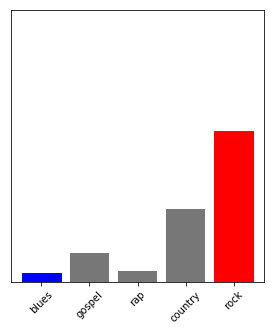

In [6]:
def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(5), predictions_array, color="#777777")
    plt.ylim([0, 1]) 
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')
    
i = 500
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plot_value_array(i, Y_hat,  Y)
_ = plt.xticks(range(5), GENRE_NAMES, rotation=45)

Confusion matrix, without normalization
[[ 354   39  113  166  798]
 [  11  946  123  147  595]
 [   5   24 1944    6  208]
 [  94  255   95  950 1868]
 [ 119  122  256  264 2349]]
Normalized confusion matrix
[[0.24 0.03 0.08 0.11 0.54]
 [0.01 0.52 0.07 0.08 0.33]
 [0.   0.01 0.89 0.   0.1 ]
 [0.03 0.08 0.03 0.29 0.57]
 [0.04 0.04 0.08 0.08 0.76]]


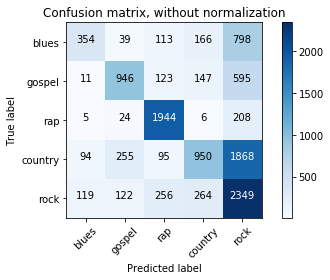

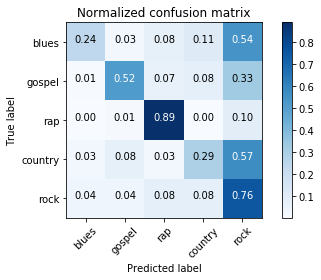

F1 Scores:
['blues', 'gospel', 'rap', 'country', 'rock']


array([0.34, 0.59, 0.82, 0.4 , 0.53])

In [7]:
### DISPLAY PERFORMANCE STATISTICS

## Adapted from https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(Y, Y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=GENRE_NAMES, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# Print F1 Scores
print("F1 Scores:")
print(GENRE_NAMES)
f1_score(Y, Y_pred, average=None)


In [21]:
# Calculate Gradients
def calculate_gradients():
    output_tens = predictions
    input_tens = inputs

    grad = [tf.gradients(output_tens[i], input_tens) for i in range(output_tens.shape[1])]

    sess = tf.keras.backend.get_session()
    grad_val = np.squeeze(np.array(sess.run(grad, feed_dict={input_tens: X})))
    return grad_val

grad_val = calculate_gradients()

In [24]:
def get_activations(label_true, label_pred):
    pred_idx = set(np.squeeze(np.argwhere(Y_pred == GENRES_IDX[label_pred])))
    true_idx = set(np.squeeze(np.argwhere(Y == GENRES_IDX[label_true])))
    target_idx = pred_idx.intersection(true_idx)
    return target_idx, np.average(grad_val[:, list(target_idx), :], axis=1)

def get_lyrics(label_true, label_pred):
    pred_idx = set(np.squeeze(np.argwhere(Y_pred == GENRES_IDX[label_pred])))
    true_idx = set(np.squeeze(np.argwhere(Y == GENRES_IDX[label_true])))
    target_idx = list(pred_idx.intersection(true_idx))
    return lyrics[target_idx]

EXAMINE_ACTIVATIONS = False
if EXAMINE_ACTIVATIONS:
    label_true = "rock"
    label_pred = "blues"
    for label_true in GENRE_NAMES:
        for label_pred in GENRE_NAMES:
            print("True label: "+ label_true)
            print("Predicted label: "+ label_pred)
            target_idx, activations = get_activations(label_true, label_pred)
            print(sparse.csr_matrix(activations))

EXAMINE_LYRICS = False
if EXAMINE_LYRICS:
    label_true = "blues"
    label_pred = "rock"
    lyrics_target = get_lyrics(label_true, label_pred)
    print(len(lyrics_target))
    print(lyrics_target[0])



In [25]:
def get_derivative(x, eps = 1e-10):
    y = model.predict(x)
    h = 10
    dy_old = np.array([0]*5)
    dy_new = np.array([100]*5)
    while(max(abs(dy_old - dy_new)) > eps):
        dx = np.zeros_like(x)
        dx[0] = h
        x2 = x + dx
        y2 = model.predict(np.array(x2))
        dy_new = (y[0] - y2[0])/h
        h = h/2
#         print(dy_new)
    return dy_new

CALCULATE_DERIVATIVES = False
if CALCULATE_DERIVATIVES:
    for i in range(X.shape[1]):
        eps = 1e-10
        x = np.array([X[i]])
        dy = get_derivative(x)
        if(max(abs(dy)) > eps):
            print(dy)